In [126]:
# !git clone git@github.com:cisagov/vulnrichment.git    

In [127]:
import os
import json
import pandas as pd

## Read JSON ADP SSVC Values into a df

In [128]:
root_directory = '../tmp/vulnrichment'

In [129]:

def extract_metrics_from_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        metrics = {}
        cve_id = os.path.splitext(os.path.basename(file_path))[0]  # Extract filename without extension as cveId
        metrics['cve'] = cve_id  # Store cveId in metrics dictionary
        containers = data.get('containers', {})
        for adp_data in containers.get('adp', []):
            metrics_data = adp_data.get('metrics', [])
            for metric in metrics_data:
                other = metric.get('other', {})
                content = other.get('content', {})
                if content.get('id') == cve_id:
                    for option in content.get('options', []):
                        if 'Exploitation' in option:
                            metrics['Exploitation'] = option['Exploitation']
                        if 'Automatable' in option:
                            metrics['Automatable'] = option['Automatable']
                        if 'Technical Impact' in option:
                            metrics['Technical Impact'] = option['Technical Impact']
        return metrics

def extract_metrics_from_directory(root_dir):
    all_metrics = []
    for root, _, files in os.walk(root_dir):
        for file_name in files:
            if file_name.endswith('.json'):
                file_path = os.path.join(root, file_name)
                metrics = extract_metrics_from_json(file_path)
                if metrics:
                    all_metrics.append(metrics)
    return all_metrics

metrics_list = extract_metrics_from_directory(root_directory)

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(metrics_list)

# Reorder columns to have 'cveId' as the first column
if 'cve' in df.columns:
    df = df[['cve', 'Exploitation', 'Automatable', 'Technical Impact']]

# Display the DataFrame (you can manipulate it further as needed)
df


,cve,Exploitation,Automatable,Technical Impact
0,CVE-2021-1675,active,no,total
1,CVE-2021-32039,none,no,partial
2,CVE-2021-42574,poc,no,total
3,CVE-2021-42295,none,no,partial
4,CVE-2021-35001,none,no,partial
...,...,...,...,...
10250,CVE-2024-37150,none,no,partial
10251,CVE-2024-37350,none,no,partial
10252,CVE-2024-37535,poc,no,partial
10253,CVE-2024-37313,none,yes,partial


## Check Values
The values are mixed case - so convert all to Title case

In [130]:
df.Exploitation.value_counts()

none      9055
poc       1016
None        57
active      55
Active      19
PoC         11
Name: Exploitation, dtype: int64

In [131]:
df.Automatable.value_counts()

no     8906
yes    1218
No       56
Yes      33
Name: Automatable, dtype: int64

In [132]:
df['Technical Impact'].value_counts()

partial    7201
total      2923
Total        85
Partial       4
Name: Technical Impact, dtype: int64

In [133]:
# Convert values in 'Exploitation', 'Automatable', 'Technical Impact' columns to title case
df['Exploitation'] = df['Exploitation'].apply(lambda x: x.title() if isinstance(x, str) else x)
df['Automatable'] = df['Automatable'].apply(lambda x: x.title() if isinstance(x, str) else x)
df['Technical Impact'] = df['Technical Impact'].apply(lambda x: x.title() if isinstance(x, str) else x)


In [134]:
df.Exploitation.value_counts()

None      9112
Poc       1027
Active      74
Name: Exploitation, dtype: int64

In [135]:
df.Automatable.value_counts()

No     8962
Yes    1251
Name: Automatable, dtype: int64

In [136]:
df['Technical Impact'].value_counts()

Partial    7205
Total      3008
Name: Technical Impact, dtype: int64

## Get CVSS Base Parameters

Several JSON files don't have CVSS base parameters or score e.g.
* vulnrichment/2024/22xxx/CVE-2024-22365.json 
* vulnrichment/2018/20xxx/CVE-2018-20735.json

````
find . -type f -name "*.json" -exec grep -H "baseScore" {} + | wc -l
9425
````

So use a different source for these.


In [137]:
URL="https://raw.githubusercontent.com/t0sche/cvss-bt/main/cvss-bt.csv"
df_cvss = pd.read_csv(URL)
df_cvss

/tmp/ipykernel_3197574/271777378.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cvss = pd.read_csv(URL)


,cve,cvss-bt_score,cvss-bt_severity,cvss-bt_vector,cvss_version,base_score,base_severity,base_vector,assigner,published_date,epss,cisa_kev,vulncheck_kev,exploitdb,metasploit,nuclei,poc_github
0,CVE-1999-0095,9.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:POC,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-10-01T04:00Z,0.07764,False,False,True,False,False,False
1,CVE-1999-0082,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-11-11T05:00Z,0.015,False,False,False,False,False,False
2,CVE-1999-1471,6.1,MEDIUM,AV:L/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,7.2,HIGH,AV:L/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-01-01T05:00Z,0.00043,False,False,False,False,False,False
3,CVE-1999-1122,3.9,LOW,AV:L/AC:L/Au:N/C:P/I:P/A:P/E:U,2.0,4.6,MEDIUM,AV:L/AC:L/Au:N/C:P/I:P/A:P,cve@mitre.org,1989-07-26T04:00Z,0.0006,False,False,False,False,False,False
4,CVE-1999-1467,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-10-26T04:00Z,0.00299,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254275,CVE-2024-5574,6.9,MEDIUM,CVSS:3.1/AV:N/AC:H/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,7.5,HIGH,CVSS:3.1/AV:N/AC:H/PR:L/UI:N/S:U/C:H/I:H/A:H,cve-request@wordfence.com,2024-06-19T06:15Z,0.00056,False,False,False,False,False,False
254276,CVE-2024-5853,9.1,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:H/I:H/A:H/E:U,3.1,9.9,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:H/I:H/A:H,cve-request@wordfence.com,2024-06-19T06:15Z,0.0005,False,False,False,False,False,False
254277,CVE-2024-5343,5.9,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N/E:U,3.1,6.4,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,cve-request@wordfence.com,2024-06-19T06:15Z,0.00045,False,False,False,False,False,False
254278,CVE-2024-6132,8.1,HIGH,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,8.8,HIGH,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,cve-request@wordfence.com,2024-06-19T06:15Z,0.0005,False,False,False,False,False,False


In [138]:
# Merge df and df_cvss on 'cveId', adding 'base_vector' column from df_cvss to df
df_merged = pd.merge(df, df_cvss[['cve', 'base_vector', 'cisa_kev', 'nuclei', 'metasploit', 'exploitdb', 'poc_github']], on='cve', how='left')
df_merged

,cve,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github
0,CVE-2021-1675,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True
1,CVE-2021-32039,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False
2,CVE-2021-42574,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True
3,CVE-2021-42295,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False
4,CVE-2021-35001,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
10250,CVE-2024-37150,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False
10251,CVE-2024-37350,None,No,Partial,NaN,NaN,NaN,NaN,NaN,NaN
10252,CVE-2024-37535,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False
10253,CVE-2024-37313,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False


In [139]:
df_merged['base_vector'].isna().sum()

220

In [140]:
# Drop rows with NaN values in 'base_vector' column
df_merged.dropna(subset=['base_vector'], inplace=True)
df_merged

,cve,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github
0,CVE-2021-1675,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True
1,CVE-2021-32039,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False
2,CVE-2021-42574,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True
3,CVE-2021-42295,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False
4,CVE-2021-35001,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False
10250,CVE-2024-37150,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False
10252,CVE-2024-37535,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False
10253,CVE-2024-37313,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False


In [141]:
df_merged

,cve,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github
0,CVE-2021-1675,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True
1,CVE-2021-32039,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False
2,CVE-2021-42574,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True
3,CVE-2021-42295,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False
4,CVE-2021-35001,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False
10250,CVE-2024-37150,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False
10252,CVE-2024-37535,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False
10253,CVE-2024-37313,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False


In [157]:
def exploitation_dt(row):
    if row['cisa_kev']:
        return "Active"
    elif (row['exploitdb'] | row['poc_github'] | row['nuclei'] | row['metasploit']):
    #elif (row['exploitdb'] | row['poc_github'] ):
        return "Poc"
    else:
        return "None"

In [158]:
df_merged['_Exploitation'] = df_merged.apply(exploitation_dt, axis=1)
df_merged


,cve,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,_Exploitation,cvss_vector_dict,_Technical Impact,_Automatable,Differences,Difference Category
0,CVE-2021-1675,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True,Active,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,[],Same
1,CVE-2021-32039,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'L...",Partial,No,[],Same
2,CVE-2021-42574,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True,Poc,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'N...",Total,No,[],Same
3,CVE-2021-42295,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Partial,No,[],Same
4,CVE-2021-35001,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,[Technical Impact],Differ by 1 value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,[Automatable],Differ by 1 value
10250,CVE-2024-37150,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'N...",Partial,Yes,[Automatable],Differ by 1 value
10252,CVE-2024-37535,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Total,Yes,"[Exploitation, Automatable, Technical Impact]",Differ by more than 2 values
10253,CVE-2024-37313,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,[],Same


In [159]:
# Function to convert CVSS vector string to dictionary
def cvss_vector_to_dict(cvss_vector):
    cvss_dict = {}
    elements = cvss_vector.split('/')
    for element in elements:
        key, value = element.split(':')
        cvss_dict[key] = value
    return cvss_dict

In [160]:
# Add cvss_vector_dict column
df_merged['cvss_vector_dict'] = df_merged['base_vector'].apply(cvss_vector_to_dict)
df_merged

,cve,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,_Exploitation,cvss_vector_dict,_Technical Impact,_Automatable,Differences,Difference Category
0,CVE-2021-1675,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True,Active,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,[],Same
1,CVE-2021-32039,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'L...",Partial,No,[],Same
2,CVE-2021-42574,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True,Poc,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'N...",Total,No,[],Same
3,CVE-2021-42295,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Partial,No,[],Same
4,CVE-2021-35001,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,[Technical Impact],Differ by 1 value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,[Automatable],Differ by 1 value
10250,CVE-2024-37150,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'N...",Partial,Yes,[Automatable],Differ by 1 value
10252,CVE-2024-37535,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Total,Yes,"[Exploitation, Automatable, Technical Impact]",Differ by more than 2 values
10253,CVE-2024-37313,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,[],Same


In [161]:
#V3 base score parameters
#https://www.first.org/cvss/v3-1/ or https://www.first.org/cvss/v3-0
#'availabilityImpact/'confidentialityImpact', 'integrityImpact'}
#Low (L)
#High (H)
#None (N)

#https://www.first.org/cvss/v2/guide
#Confidentiality/Integrity/Availability:
#None (N)
#Partial (P)
#Complete (C)

# Function to determine impact
def technical_impact_dt(cvss_dict):
    if (('CVSS' in cvss_dict and ((cvss_dict['CVSS'] == '3.1' ) | (cvss_dict['CVSS'] == '3.0')) and  (cvss_dict['C'] == 'H') and (cvss_dict['I'] == 'H')))  or (('C' in cvss_dict and cvss_dict['C'] == 'C') and ('I' in cvss_dict and cvss_dict['I'] == 'C')):
        return "Total"
    else:
        return "Partial"


In [162]:
df_merged['_Technical Impact'] = df_merged['cvss_vector_dict'].apply(technical_impact_dt)
df_merged

,cve,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,_Exploitation,cvss_vector_dict,_Technical Impact,_Automatable,Differences,Difference Category
0,CVE-2021-1675,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True,Active,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,[],Same
1,CVE-2021-32039,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'L...",Partial,No,[],Same
2,CVE-2021-42574,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True,Poc,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'N...",Total,No,[],Same
3,CVE-2021-42295,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Partial,No,[],Same
4,CVE-2021-35001,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,[Technical Impact],Differ by 1 value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,[Automatable],Differ by 1 value
10250,CVE-2024-37150,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'N...",Partial,Yes,[Automatable],Differ by 1 value
10252,CVE-2024-37535,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Total,Yes,"[Exploitation, Automatable, Technical Impact]",Differ by more than 2 values
10253,CVE-2024-37313,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,[],Same


In [163]:
def automatable_dt(cvss_dict):

    # ((userInteraction == 'NONE') & (attackComplexity == 'LOW') & (privilegesRequired != 'HIGH') & (attackVector == 'NETWORK')):
    if (('CVSS' in cvss_dict and ((cvss_dict['CVSS'] == '3.1') | (cvss_dict['CVSS'] == '3.0')) and  cvss_dict['UI'] == 'N' and cvss_dict['AC'] == 'L' and cvss_dict['PR'] != 'H' and cvss_dict['AV'] == 'N') or \
    (cvss_dict['AC'] == 'L' and cvss_dict['AV'] == 'N' and ('Au' in cvss_dict and cvss_dict['Au'] == 'N'))) :

        return "Yes"
    else:
        return "No"

In [164]:
df_merged['_Automatable'] = df_merged['cvss_vector_dict'].apply(automatable_dt)
df_merged

,cve,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,_Exploitation,cvss_vector_dict,_Technical Impact,_Automatable,Differences,Difference Category
0,CVE-2021-1675,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True,Active,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,[],Same
1,CVE-2021-32039,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'L...",Partial,No,[],Same
2,CVE-2021-42574,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True,Poc,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'N...",Total,No,[],Same
3,CVE-2021-42295,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Partial,No,[],Same
4,CVE-2021-35001,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,[Technical Impact],Differ by 1 value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,[Automatable],Differ by 1 value
10250,CVE-2024-37150,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'N...",Partial,Yes,[Automatable],Differ by 1 value
10252,CVE-2024-37535,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Total,Yes,"[Exploitation, Automatable, Technical Impact]",Differ by more than 2 values
10253,CVE-2024-37313,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,[],Same


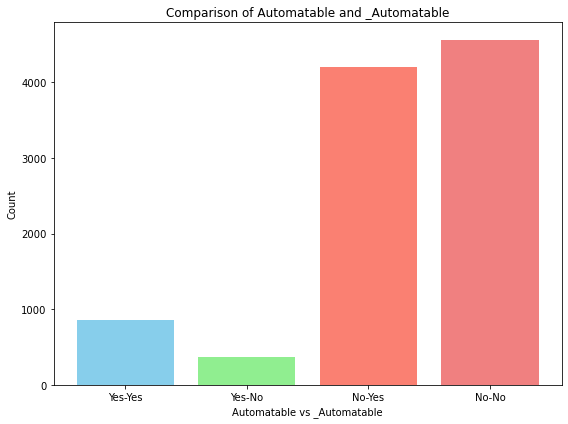

In [165]:

# Count occurrences of each combination
count_yes_yes = ((df_merged['Automatable'] == 'Yes') & (df_merged['_Automatable'] == 'Yes')).sum()
count_yes_no = ((df_merged['Automatable'] == 'Yes') & (df_merged['_Automatable'] == 'No')).sum()
count_no_yes = ((df_merged['Automatable'] == 'No') & (df_merged['_Automatable'] == 'Yes')).sum()
count_no_no = ((df_merged['Automatable'] == 'No') & (df_merged['_Automatable'] == 'No')).sum()

# Prepare data for plotting
categories = ['Yes-Yes', 'Yes-No', 'No-Yes', 'No-No']
values = [count_yes_yes, count_yes_no, count_no_yes, count_no_no]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.xlabel('Automatable vs _Automatable')
plt.ylabel('Count')
plt.title('Comparison of Automatable and _Automatable')
plt.tight_layout()

# Display the plot
plt.show()

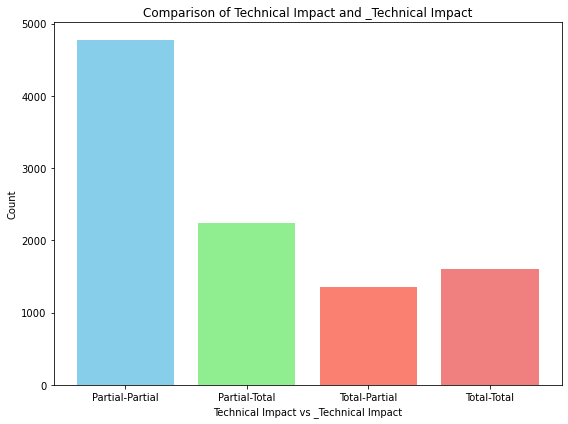

In [166]:
# Count occurrences of each combination
count_partial_partial = ((df_merged['Technical Impact'] == 'Partial') & (df_merged['_Technical Impact'] == 'Partial')).sum()
count_partial_total = ((df_merged['Technical Impact'] == 'Partial') & (df_merged['_Technical Impact'] == 'Total')).sum()
count_total_partial = ((df_merged['Technical Impact'] == 'Total') & (df_merged['_Technical Impact'] == 'Partial')).sum()
count_total_total = ((df_merged['Technical Impact'] == 'Total') & (df_merged['_Technical Impact'] == 'Total')).sum()

# Prepare data for plotting
categories = ['Partial-Partial', 'Partial-Total', 'Total-Partial', 'Total-Total']
values = [count_partial_partial, count_partial_total, count_total_partial, count_total_total]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.xlabel('Technical Impact vs _Technical Impact')
plt.ylabel('Count')
plt.title('Comparison of Technical Impact and _Technical Impact')
plt.tight_layout()

# Display the plot
plt.show()

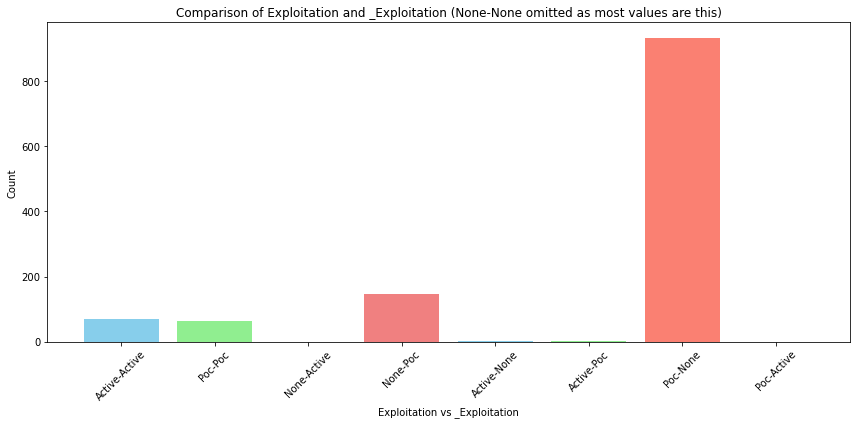

In [167]:
# Count occurrences of each combination
count_none_none = ((df_merged['Exploitation'] == 'None') & (df_merged['_Exploitation'] == 'None')).sum()
count_active_active = ((df_merged['Exploitation'] == 'Active') & (df_merged['_Exploitation'] == 'Active')).sum()
count_poc_poc = ((df_merged['Exploitation'] == 'Poc') & (df_merged['_Exploitation'] == 'Poc')).sum()
count_none_active = ((df_merged['Exploitation'] == 'None') & (df_merged['_Exploitation'] == 'Active')).sum()
count_none_poc = ((df_merged['Exploitation'] == 'None') & (df_merged['_Exploitation'] == 'Poc')).sum()
count_active_none = ((df_merged['Exploitation'] == 'Active') & (df_merged['_Exploitation'] == 'None')).sum()
count_active_poc = ((df_merged['Exploitation'] == 'Active') & (df_merged['_Exploitation'] == 'Poc')).sum()
count_poc_none = ((df_merged['Exploitation'] == 'Poc') & (df_merged['_Exploitation'] == 'None')).sum()
count_poc_active = ((df_merged['Exploitation'] == 'Poc') & (df_merged['_Exploitation'] == 'Active')).sum()

# Prepare data for plotting

categories = ['Active-Active', 'Poc-Poc', 'None-Active', 'None-Poc', 'Active-None', 'Active-Poc', 'Poc-None', 'Poc-Active']
values = [
    count_active_active, count_poc_poc, 
    count_none_active, count_none_poc, count_active_none, 
    count_active_poc, count_poc_none, count_poc_active
]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(categories, values, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.xlabel('Exploitation vs _Exploitation')
plt.ylabel('Count')
plt.title('Comparison of Exploitation and _Exploitation (None-None omitted as most values are this)')
plt.xticks(rotation=45)
plt.tight_layout()

In [168]:
df_merged.dropna(subset=['Exploitation', '_Exploitation'], inplace=True)
df_merged

,cve,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,_Exploitation,cvss_vector_dict,_Technical Impact,_Automatable,Differences,Difference Category
0,CVE-2021-1675,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True,Active,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,[],Same
1,CVE-2021-32039,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'L...",Partial,No,[],Same
2,CVE-2021-42574,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True,Poc,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'N...",Total,No,[],Same
3,CVE-2021-42295,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Partial,No,[],Same
4,CVE-2021-35001,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,[Technical Impact],Differ by 1 value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,[Automatable],Differ by 1 value
10250,CVE-2024-37150,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'N...",Partial,Yes,[Automatable],Differ by 1 value
10252,CVE-2024-37535,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Total,Yes,"[Exploitation, Automatable, Technical Impact]",Differ by more than 2 values
10253,CVE-2024-37313,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,[],Same


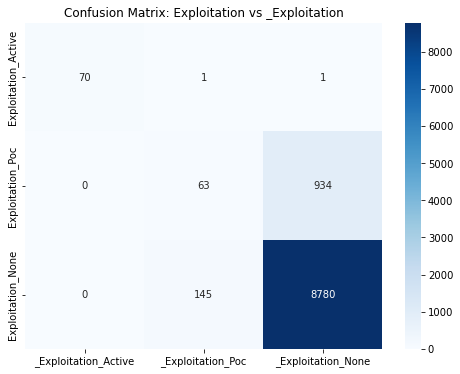

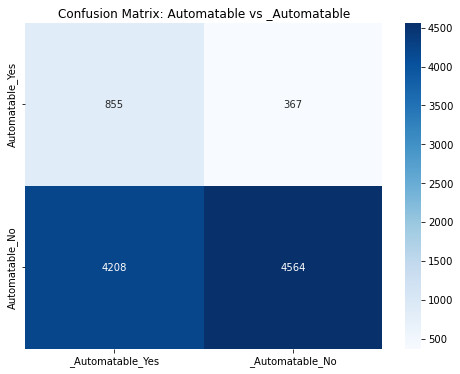

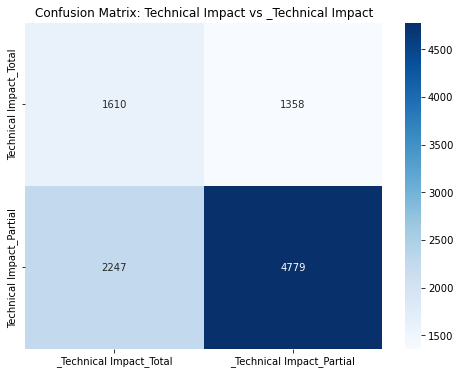

In [171]:

# Define a function to plot confusion matrix
def plot_confusion_matrix(df, col1, col2, labels, title):
    conf_matrix = confusion_matrix(df[col1], df[col2], labels=labels)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'{col1}_{label}' for label in labels],
                                  columns=[f'{col2}_{label}' for label in labels])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.show()

# Plotting confusion matrices for the specified columns
plot_confusion_matrix(df_merged, 'Exploitation', '_Exploitation', ['Active', 'Poc', 'None'], 'Confusion Matrix: Exploitation vs _Exploitation')
plot_confusion_matrix(df_merged, 'Automatable', '_Automatable', ['Yes', 'No'], 'Confusion Matrix: Automatable vs _Automatable')
plot_confusion_matrix(df_merged, 'Technical Impact', '_Technical Impact', ['Total', 'Partial'], 'Confusion Matrix: Technical Impact vs _Technical Impact')

/home/chris/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:677: UserWarning: The handle <BarContainer object of 3 artists> has a label of '_Exploitation' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


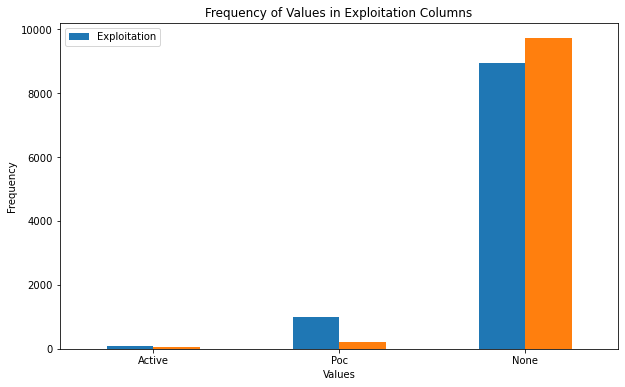

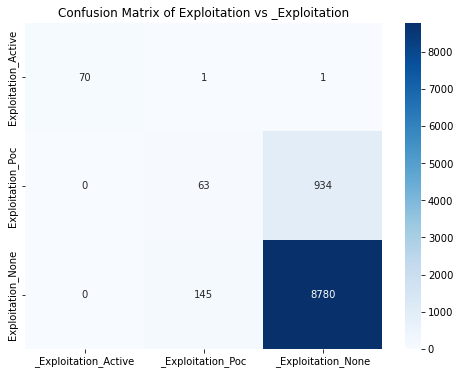

Percentage of Agreement between 'Exploitation' and '_Exploitation': 89.18%


In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# 1. Count the Frequency of Each Value
def count_values(column):
    return column.value_counts().reindex(['Active', 'Poc', 'None'], fill_value=0)

exploitation_counts = count_values(df_merged['Exploitation'])
_exploitation_counts = count_values(df_merged['_Exploitation'])

count_df = pd.DataFrame({
    'Exploitation': exploitation_counts,
    '_Exploitation': _exploitation_counts
})

# Plotting the frequency counts
count_df.plot(kind='bar', figsize=(10, 6))
plt.title('Frequency of Values in Exploitation Columns')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

# 2. Confusion Matrix
conf_matrix = confusion_matrix(df_merged['Exploitation'], df_merged['_Exploitation'], labels=['Active', 'Poc', 'None'])
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Exploitation_Active', 'Exploitation_Poc', 'Exploitation_None'],
                              columns=['_Exploitation_Active', '_Exploitation_Poc', '_Exploitation_None'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Exploitation vs _Exploitation')
plt.show()

# 3. Percentage Agreement
agreement = (df_merged['Exploitation'] == df_merged['_Exploitation']).mean() * 100
print(f"Percentage of Agreement between 'Exploitation' and '_Exploitation': {agreement:.2f}%")

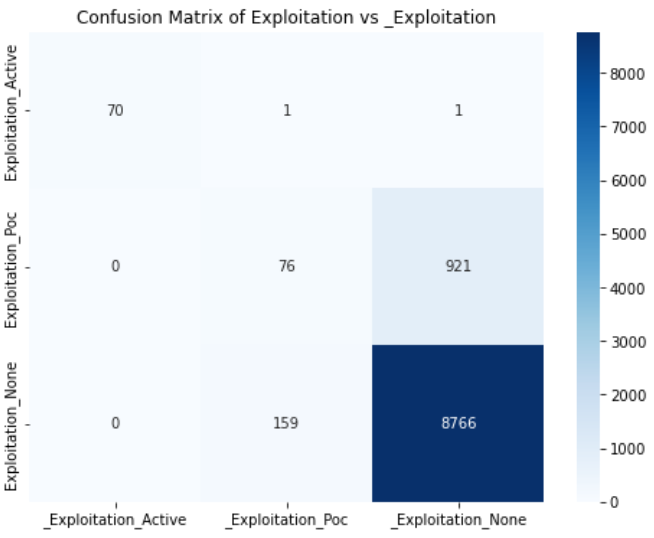

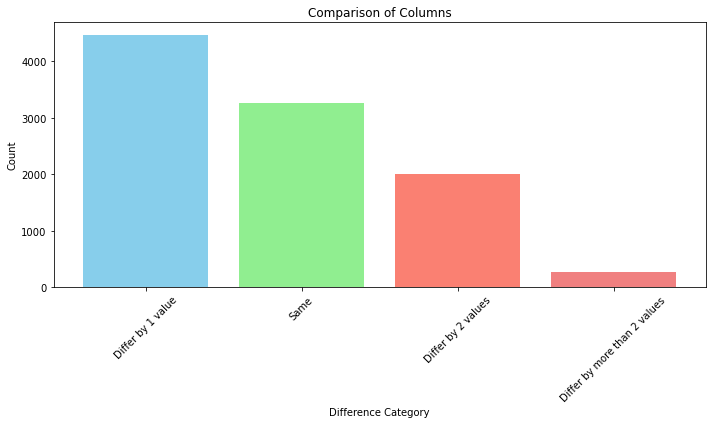

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Function to compare columns and count differences
def compare_columns(row):
    cols_to_compare = ['Exploitation', 'Automatable', 'Technical Impact']
    diffs = []
    for col in cols_to_compare:
        if row[col] != row[f'_{col}']:
            diffs.append(col)
    return diffs

# Apply compare_columns function to each row
df_merged['Differences'] = df_merged.apply(compare_columns, axis=1)

# Function to categorize differences based on count
def categorize_differences(diffs):
    count = len(diffs)
    if count == 0:
        return 'Same'
    elif count == 1:
        return 'Differ by 1 value'
    elif count == 2:
        return 'Differ by 2 values'
    else:
        return 'Differ by more than 2 values'

# Apply categorize_differences function to 'Differences' column
df_merged['Difference Category'] = df_merged['Differences'].apply(categorize_differences)

# Count occurrences of each Difference Category
diff_counts = df_merged['Difference Category'].value_counts()

# Prepare data for plotting
categories = diff_counts.index
values = diff_counts.values

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.xlabel('Difference Category')
plt.ylabel('Count')
plt.title('Comparison of Columns')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()
